# Предсказание активности молекул по отношению к таргету

*При подготовке ноутбука использовались данные из соревнования [Global AI Challenge](https://codenrock.com/contests/global-ai#/)* 

Целью данной задачи является предсказание активности молекулы лиганда по отношению к таргету - Covid 19

![](https://cloudfront.jove.com/files/media/science-education/science-education-thumbs/11513.jpg)

## План анализа данных:

  1. Загрузить данные для обучения
  2. Обработать данные перед обучением модели
  3. Обучить модель на обучающей выборке
  4. Загрузить и предобработать данные для тестирования
  5. Провалидировать модель на тестовой выборке


# 0. Установка и импорт библиотек

In [ ]:
# Grab Jaime's excellent condacolab package: https://github.com/jaimergp/condacolab
# Note: you should probably read the README file at that repo.
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
!conda install -c conda-forge chembl_structure_pipeline

In [ ]:
!pip install  dgl
!pip install dgllife

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 1. Загрузка данных

In [ ]:
!wget https://www.dropbox.com/s/48c34raijlxc0nw/train.csv
!wget https://www.dropbox.com/s/297trreazro8ivr/test_labels.csv

In [2]:
DATA_PATH = "./"
TRAIN_FILE = "train.csv"
TEST_FILE = "test_labels.csv"

SMILES_COLUMN = "smiles"
TARGET_COLUMN = "Active"

In [3]:
import pandas as pd

def load_train_test_data():
    train_csv_path = os.path.join(DATA_PATH, TRAIN_FILE)
    test_csv_path = os.path.join(DATA_PATH, TEST_FILE)
    train_data = pd.read_csv(train_csv_path, index_col = 0)
    test_data = pd.read_csv(test_csv_path,index_col = 0)
    return train_data.rename(columns = {"Smiles":SMILES_COLUMN}), test_data.rename(columns = {"Smiles":SMILES_COLUMN})

## 1.1 Анализ данных, формулировка задачи машинного обучения

Молекулы представлены в виде [SMILES нотации](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system).

![](https://upload.wikimedia.org/wikipedia/commons/thumb/0/00/SMILES.png/450px-SMILES.png)

In [4]:
train_data, test_data = load_train_test_data()
train_data.head()

,smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5557 entries, 0 to 5556
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   smiles  5557 non-null   object
 1   Active  5557 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 92.3+ KB


In [6]:
train_data[TARGET_COLUMN].value_counts()

False    5351
True      206
Name: Active, dtype: int64

## 1.2 Предобработка данных

In [7]:
from rdkit import Chem
from rdkit.Chem.SaltRemover import SaltRemover

In [8]:
def remove_salts_and_canonicalized(smiles: str):
    remover = SaltRemover(defnData="[Cl,Br]")
    mol = Chem.MolFromSmiles(smiles)
    res = remover.StripMol(mol)
    processed_smiles = Chem.MolToSmiles(res)
    return processed_smiles

In [9]:
train_data[SMILES_COLUMN] = list(map(remove_salts_and_canonicalized, train_data[SMILES_COLUMN]))
test_data[SMILES_COLUMN] = list(map(remove_salts_and_canonicalized, test_data[SMILES_COLUMN]))

In [10]:
def change_str_target_to_int(targets: pd.Series):
    target_map = {True: 1, False: 0}
    processed_targets = targets.map(target_map)
    return processed_targets.values

In [11]:
train_data[TARGET_COLUMN] = change_str_target_to_int(train_data[TARGET_COLUMN])
test_data[TARGET_COLUMN] = change_str_target_to_int(test_data[TARGET_COLUMN])

In [12]:
train_data.head()

,smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,0
1,CCCN1CCC[C@H](c2cccc(O)c2)C1,0
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,0
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,0
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,0


## 1.3 Feature engineering

Молекулу можно представить в виде фингерпринта - вектора свойств, полученного по определенному алгоритму.

Мы будем считать фингерпринты при помощи библиотеки RDKit. Про различные фингерпринты и их описание можно почитать тут - https://www.rdkit.org/docs/GettingStartedInPython.html#fingerprinting-and-molecular-similarity

![](https://sun9-64.userapi.com/impf/_8Zy5WO6Mt0SIPx1YS02DeErAoZ0RHcwgc-kZg/Md98bNVzBg0.jpg?size=831x415&quality=96&sign=cb20481128a04ff523fd662dd0e604ab&type=album)


### Моргановские фингерпринты (ECFP)

![](https://d3i71xaburhd42.cloudfront.net/52adf3589e8b7b9855353e5815669258ef6e3405/6-Figure2-1.png)

In [13]:
from enum import Enum
from functools import partial
from rdkit import Chem, DataStructs
from rdkit.DataStructs import ExplicitBitVect
from rdkit.Chem import AllChem, MACCSkeys
from typing import List


In [14]:
class FingerprintsNames(Enum):
    ECFP4 = "morgan_2_2048"
    RDKitFP = "RDKFingerprint"
    TOPOTORSION = "topological_torsion"
    MACCS = "MACCSkeys"
    PATTERN = "PatternFingerprint"
    ATOMPAIR = "AtomPairFingerprint"



FINGERPRINTS_METHODS = {
    FingerprintsNames.ECFP4: partial(AllChem.GetMorganFingerprintAsBitVect, radius=2, nBits=2048),
    FingerprintsNames.RDKitFP: partial(Chem.RDKFingerprint, maxPath=5),
    FingerprintsNames.TOPOTORSION: AllChem.GetHashedTopologicalTorsionFingerprintAsBitVect,
    FingerprintsNames.MACCS: MACCSkeys.GenMACCSKeys,#TODO
    FingerprintsNames.PATTERN: Chem.PatternFingerprint,#TODO
    FingerprintsNames.ATOMPAIR: AllChem.GetHashedAtomPairFingerprintAsBitVect}#TODO


In [15]:
fingerprint_type_name = FingerprintsNames.ECFP4
fingerprint_type_method = FINGERPRINTS_METHODS[fingerprint_type_name]

In [16]:
def bit_vectors_to_numpy_arrays(fps: List[ExplicitBitVect]) -> np.array:
    output_arrays = [np.zeros((1,)) for i in range(len(fps))]
    _ = list(
        map(lambda fp_output_array: DataStructs.ConvertToNumpyArray(fp_output_array[0], fp_output_array[1]),
            zip(fps, output_arrays)))
    return np.asarray(output_arrays)

def get_np_array_of_fps(fp_type, smiles: List[str]):
    # Calculate the morgan fingerprint
    mols = [Chem.MolFromSmiles(m) for m in smiles]
    fp = list(map(fp_type, mols))
    return bit_vectors_to_numpy_arrays(fp)

In [17]:
train_fp = get_np_array_of_fps(fp_type=fingerprint_type_method, smiles=train_data[SMILES_COLUMN])
test_fp = get_np_array_of_fps(fp_type=fingerprint_type_method, smiles=test_data[SMILES_COLUMN])

In [18]:
y_train = train_data[TARGET_COLUMN]
y_test = test_data[TARGET_COLUMN]

# 2. Подготовка к обучению модели

## 2.1 Кросс-валидация

![](https://pubs.rsc.org/image/article/2018/SC/c7sc02664a/c7sc02664a-f3_hi-res.gif)

In [ ]:
#!conda create -n env_pytorch python
!conda activate env_pytorch

In [19]:
from dgllife.utils import ScaffoldSplitter

Using backend: pytorch


In [20]:
class ScaffoldCVSklearn:
    def __init__(self, data, k_folds):
        self.scaffold_splits = ScaffoldSplitter.k_fold_split(data, k=k_folds)

    def split(self):
        indices_splits = []
        for train_data, val_data in self.scaffold_splits:
            train_indices = train_data.indices
            val_indices = val_data.indices
            indices_splits.append((train_indices, val_indices))
        return indices_splits

    def convert_data_to_indices(self, dataset):
        indices = [index for index, row in dataset.iterrows()]
        return indices


In [21]:
cv = ScaffoldCVSklearn(train_data, k_folds=3).split()

Start initializing RDKit molecule instances...
Creating RDKit molecule instance 1000/5557
Creating RDKit molecule instance 2000/5557
Creating RDKit molecule instance 3000/5557
Creating RDKit molecule instance 4000/5557
Creating RDKit molecule instance 5000/5557
Start computing Bemis-Murcko scaffolds.
Computing Bemis-Murcko for compound 1000/5557
Computing Bemis-Murcko for compound 2000/5557
Computing Bemis-Murcko for compound 3000/5557
Computing Bemis-Murcko for compound 4000/5557
Computing Bemis-Murcko for compound 5000/5557
Processing fold 1/3
Processing fold 2/3
Processing fold 3/3


## 2.2 Установка модели

In [22]:
from xgboost import XGBClassifier

In [23]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, nthread=1, use_label_encoder=False)

In [24]:
params = {
        'max_depth': [10, 20, 30],
        'n_estimators': [100]
    }

## 2.3 Поиск параметров

In [26]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

grid_search = GridSearchCV(xgb, param_grid=params, scoring='accuracy', n_jobs=4,
                               cv=cv, verbose=10000)

# Подбор параметров модели

In [27]:
print('\n Start Grid Search')
grid_search.fit(train_fp, y_train)


 Start Grid Search
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[22:31:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=[([5, 6, 13, 81, 96, 126, 149, 160, 163, 175, 194, 196, 230,
                   248, 260, 280, 283, 287, 301, 320, 329, 353, 392, 393, 394,
                   409, 430, 443, 462, 490, ...],
                  [22, 49, 52, 67, 103, 107, 154, 184, 188, 202, 214, 225, 226,
                   229, 236, 254, 266, 292, 293, 302, 308, 313, 331, 382, 383,
                   402, 454, 474, 477, 482, ...]),
                 ([22, 49, 52, 67, 103, 107, 154, 184, 188, 202, 214, 225, 226,
                   229, 236, 254, 266, 292, 293, 302, 308, 313, 331,...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=600, n_jobs=None, nthread=1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=Non

In [28]:
print('\n All results:')
print(grid_search.cv_results_)
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized score')
print(grid_search.best_score_)
print('\n Best hyperparameters:')
print(grid_search.best_params_)


 All results:
{'mean_fit_time': array([ 56.40964611, 113.70213381, 142.55176942]), 'std_fit_time': array([ 0.25431669,  1.4967031 , 12.8380594 ]), 'mean_score_time': array([0.15225991, 0.15757863, 0.14033246]), 'std_score_time': array([0.00692637, 0.00293483, 0.01241946]), 'param_max_depth': masked_array(data=[10, 20, 30],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[100, 100, 100],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 10, 'n_estimators': 100}, {'max_depth': 20, 'n_estimators': 100}, {'max_depth': 30, 'n_estimators': 100}], 'split0_test_score': array([0.95412844, 0.95520777, 0.95574744]), 'split1_test_score': array([0.96706263, 0.96598272, 0.96814255]), 'split2_test_score': array([0.96976242, 0.96922246, 0.97084233]), 'mean_test_score': array([0.96365116, 0.96347098, 0.96491077]), 'std_test_score': array([0.00682319, 0.00

# Обучение и оценка модели

In [29]:
xgb = XGBClassifier(max_depth=10, n_estimators=100, learning_rate=0.02,  nthread=1, use_label_encoder=False)

In [30]:
xgb.fit(train_fp, y_train)

[22:34:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=1, nthread=1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [31]:
test_predictions = xgb.predict(test_fp)

In [37]:
from sklearn.metrics import f1_score

In [33]:
score = f1_score(y_test, test_predictions)
print(f"Best model test f1 score is {round(score, 3)}")

Best model test f1 score is 0.265


# Задание (10 баллов + 3 бонусных)
1. (3 балла) Добавить решение проблемы несбалансированной классификации

Варианты:
* UnderSampling
* OverSampling
* SMOTE
* Внутренние инструменты модели (`scale_pos_weight`)

2. (2 балла) Использовать еще 2 вида фингерпринтов из `FingerprintsNames`

3. (3 балла) Получить f1-score на тестовом датасете больше 0.35

Варианты:
* Увеличить количество параметров в подборе гиперпараметров
* Использовать другие алгоритмы подбора гиперпараметров (например, [RandomizedSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html))
* Использовать другие модели (Random Forest, SVC, MLPClassifier, etc)

4. (2 балла) Логирование

В качестве финального результата предоставьте таблицу (можно `pd.DataFrame`) c колонками: Model, Fingerprint, Best Parameters, Mean Cross-Validation Score, Std Cross-Validation Score, Test Score 

Проанализируйте результаты: 
* Какие фингерпринты дали лучший результат?
* Какая модель дала лучший результат.
* Коррелируют ли скоры на кросс-валидации и тестовой выборке?

5. (Бонус +3 балла) Получить f1-score на тестовом датасете больше 0.45

### 1. (3 балла) Добавить решение проблемы несбалансированной классификации

#### UnderSampling

In [22]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_uresampled, y_uresampled = rus.fit_resample(train_fp, y_train)

In [35]:
len(X_uresampled)

412

#### OverSampling

In [23]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_oresampled, y_oresampled = ros.fit_resample(train_fp, y_train)

In [37]:
len(X_oresampled)

10702

#### SMOTE

In [24]:
from imblearn.over_sampling import SMOTE
X_sresampled, y_sresampled = SMOTE().fit_resample(train_fp, y_train)

In [39]:
len(X_sresampled)

10702

#### Внутренние инструменты модели (`scale_pos_weight`)

Используем внутренний инструмент, сразу обучив модель, используя его, и посчитав f1. 

In [40]:
xgb = XGBClassifier(max_depth=20, n_estimators=200, learning_rate=0.02,  nthread=1, use_label_encoder=False, 
                    scale_pos_weight = float(np.sum(y_train == 0)) / np.sum(y_train==1))

In [41]:
xgb.fit(train_fp, y_train)

[22:35:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=20, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=1, nthread=1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=25.975728155339805,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [43]:
test_predictions = xgb.predict(test_fp)
score = f1_score(y_test, test_predictions)
print(f"Best model test f1 score is {round(score, 3)}")

Best model test f1 score is 0.35


### 2. (2 балла) Использовать еще 2 вида фингерпринтов из FingerprintsNames

#### MACCS

In [25]:
fingerprint_type_name = FingerprintsNames.MACCS
fingerprint_type_method = FINGERPRINTS_METHODS[fingerprint_type_name]

In [26]:
train_fp2 = get_np_array_of_fps(fp_type=fingerprint_type_method, smiles=train_data[SMILES_COLUMN])
test_fp2 = get_np_array_of_fps(fp_type=fingerprint_type_method, smiles=test_data[SMILES_COLUMN])

In [27]:
y_train2 = train_data[TARGET_COLUMN]
y_test2 = test_data[TARGET_COLUMN]

#### TOPOTORSION

In [47]:
fingerprint_type_name = FingerprintsNames.TOPOTORSION
fingerprint_type_method = FINGERPRINTS_METHODS[fingerprint_type_name]

In [48]:
train_fp3 = get_np_array_of_fps(fp_type=fingerprint_type_method, smiles=train_data[SMILES_COLUMN])
test_fp3 = get_np_array_of_fps(fp_type=fingerprint_type_method, smiles=test_data[SMILES_COLUMN])

In [49]:
y_train3 = train_data[TARGET_COLUMN]
y_test3 = test_data[TARGET_COLUMN]

### 3. (3 балла) Получить f1-score на тестовом датасете больше 0.35

In [50]:
from imblearn.over_sampling import SMOTE
X_sresampled, y_sresampled = SMOTE().fit_resample(train_fp2, y_train2)

#### Увеличить количество параметров в подборе гиперпараметров

In [51]:
params = {
        'max_depth': [8, 10, 20, 30],
        'n_estimators': [10, 50, 100]
}

In [32]:
from sklearn.model_selection import GridSearchCV

In [53]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(xgb, param_grid=params, scoring='f1', n_jobs=4,
                               cv=cv, verbose=10000)

In [54]:
print('\n Start Grid Search')
grid_search.fit(X_sresampled, y_sresampled)


 Start Grid Search
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[22:41:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=[([5, 6, 13, 81, 96, 126, 149, 160, 163, 175, 194, 196, 230,
                   248, 260, 280, 283, 287, 301, 320, 329, 353, 392, 393, 394,
                   409, 430, 443, 462, 490, ...],
                  [22, 49, 52, 67, 103, 107, 154, 184, 188, 202, 214, 225, 226,
                   229, 236, 254, 266, 292, 293, 302, 308, 313, 331, 382, 383,
                   402, 454, 474, 477, 482, ...]),
                 ([22, 49, 52, 67, 103, 107, 154, 184, 188, 202, 214, 225, 226,
                   229, 236, 254, 266, 292, 293, 302, 308, 313, 331,...
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=200, n_jobs=1, nthread=1,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=25.975728155339805,
                                     subsample=1,

In [55]:
print('\n All results:')
print(grid_search.cv_results_)
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized score')
print(grid_search.best_score_)
print('\n Best hyperparameters:')
print(grid_search.best_params_)


 All results:
{'mean_fit_time': array([0.44959331, 2.02210426, 3.88113348, 0.54422871, 2.70467861,
       5.43762231, 0.75779096, 4.61141197, 9.99296165, 1.15367444,
       4.72596399, 8.39936304]), 'std_fit_time': array([0.00577674, 0.00694046, 0.00182945, 0.01669309, 0.18222931,
       0.08042542, 0.02482187, 0.2888481 , 0.2297592 , 0.03992474,
       0.09956611, 0.1517883 ]), 'mean_score_time': array([0.01462928, 0.01795316, 0.02026812, 0.01396577, 0.0172871 ,
       0.02360376, 0.01595759, 0.0233295 , 0.03686754, 0.01761937,
       0.02293833, 0.03192623]), 'std_score_time': array([0.00188155, 0.00325845, 0.00236657, 0.00355417, 0.00094094,
       0.00384973, 0.00282131, 0.00293277, 0.00352178, 0.00187941,
       0.00140928, 0.00406594]), 'param_max_depth': masked_array(data=[8, 8, 8, 10, 10, 10, 20, 20, 20, 30, 30, 30],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?',
            dtyp

In [57]:
xgb = XGBClassifier(max_depth=20, n_estimators=200, learning_rate=0.2,  nthread=1, use_label_encoder=False)
xgb.fit(X_sresampled, y_sresampled)

[22:42:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=20, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=1, nthread=1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [59]:
test_predictions = xgb.predict(test_fp2)

In [60]:
score = f1_score(y_test2, test_predictions)
print(f"Best model test f1 score is {round(score, 3)}")

Best model test f1 score is 0.225


#### Использовать другие алгоритмы подбора гиперпараметров (например, RandomizedSearch)

In [61]:
from scipy.stats import randint, uniform


In [62]:
from scipy.stats import randint, uniform
import scipy.stats as sts

distributions = dict(max_depth = randint(5, 10),
                     n_estimators = randint(low=10, high=100))

In [63]:
from sklearn.model_selection import RandomizedSearchCV

grid_search = RandomizedSearchCV(xgb, param_distributions =distributions, scoring='f1', n_jobs=4,
                               cv=cv, verbose=10000)

Для первого фингерпринта

In [69]:
print('\n Start Grid Search')
grid_search.fit(train_fp, y_train)


 Start Grid Search
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[22:49:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=[([5, 6, 13, 81, 96, 126, 149, 160, 163, 175, 194, 196,
                         230, 248, 260, 280, 283, 287, 301, 320, 329, 353, 392,
                         393, 394, 409, 430, 443, 462, 490, ...],
                        [22, 49, 52, 67, 103, 107, 154, 184, 188, 202, 214, 225,
                         226, 229, 236, 254, 266, 292, 293, 302, 308, 313, 331,
                         382, 383, 402, 454, 474, 477, 482, ...]),
                       ([22, 49, 52, 67, 103, 107, 154, 184, 188, 202, 214, 225,
                         226, 229, 236, 254, 266, 292, 293, 302, 308, 31...
                                           reg_alpha=0, reg_lambda=1,
                                           scale_pos_weight=1, subsample=1,
                                           tree_method='exact',
                                           use_label_encoder=False,
                                           validate_parameters=1,
                                           verb

In [65]:
print('\n All results:')
print(grid_search.cv_results_)
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized score')
print(grid_search.best_score_)
print('\n Best hyperparameters:')
print(grid_search.best_params_)


 All results:
{'mean_fit_time': array([1.60404245, 1.57940308, 1.89461676, 2.64366817, 2.68857392,
       0.50480779, 2.79025602, 1.08761684, 2.31370966, 0.89731924]), 'std_fit_time': array([0.02216866, 0.07536307, 0.18255694, 0.04839726, 0.04025428,
       0.0163925 , 0.15331304, 0.11553815, 0.04756672, 0.07398198]), 'mean_score_time': array([0.01761866, 0.01429518, 0.01894863, 0.0156254 , 0.0211033 ,
       0.01296544, 0.01928059, 0.01429478, 0.02294175, 0.01296473]), 'std_score_time': array([0.00046918, 0.00124443, 0.00354937, 0.00308365, 0.00201385,
       0.00215505, 0.00529847, 0.00261795, 0.00163005, 0.0021552 ]), 'param_max_depth': masked_array(data=[5, 5, 7, 8, 6, 7, 6, 7, 6, 8],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[76, 72, 60, 72, 97, 19, 96, 34, 80, 29],
             mask=[False, False, False, False, False, False,

In [71]:
xgb = XGBClassifier(max_depth=8, n_estimators=72, learning_rate=0.2,  nthread=1, use_label_encoder=False, 
                    scale_pos_weight = float(np.sum(y_train2 == 0)) / np.sum(y_train2==1))
xgb.fit(train_fp, y_train)

[22:51:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=72, n_jobs=1, nthread=1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=25.975728155339805,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [72]:
test_predictions = xgb.predict(test_fp)

In [73]:
score = f1_score(y_test, test_predictions)
print(f"Best model test f1 score is {round(score, 3)}")

Best model test f1 score is 0.323


Для второго фингерпринта

In [64]:
print('\n Start Grid Search')
grid_search.fit(train_fp2, y_train2)


 Start Grid Search
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[22:44:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=[([5, 6, 13, 81, 96, 126, 149, 160, 163, 175, 194, 196,
                         230, 248, 260, 280, 283, 287, 301, 320, 329, 353, 392,
                         393, 394, 409, 430, 443, 462, 490, ...],
                        [22, 49, 52, 67, 103, 107, 154, 184, 188, 202, 214, 225,
                         226, 229, 236, 254, 266, 292, 293, 302, 308, 313, 331,
                         382, 383, 402, 454, 474, 477, 482, ...]),
                       ([22, 49, 52, 67, 103, 107, 154, 184, 188, 202, 214, 225,
                         226, 229, 236, 254, 266, 292, 293, 302, 308, 31...
                                           reg_alpha=0, reg_lambda=1,
                                           scale_pos_weight=1, subsample=1,
                                           tree_method='exact',
                                           use_label_encoder=False,
                                           validate_parameters=1,
                                           verb

In [70]:
print('\n All results:')
print(grid_search.cv_results_)
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized score')
print(grid_search.best_score_)
print('\n Best hyperparameters:')
print(grid_search.best_params_)


 All results:
{'mean_fit_time': array([15.50796819, 20.5991048 , 14.32243069,  7.04584702, 19.37976305,
       53.44322896, 17.73688634, 25.43620404, 38.72562742, 28.35603786]), 'std_fit_time': array([0.04739383, 1.98585609, 0.46740693, 0.05263384, 0.07634486,
       0.98087957, 0.34845235, 0.16100528, 1.29494183, 2.91137513]), 'mean_score_time': array([0.12832085, 0.13066212, 0.13065235, 0.13896314, 0.12511722,
       0.14428027, 0.13065139, 0.12133265, 0.12002571, 0.10272662]), 'std_score_time': array([0.02223417, 0.00571035, 0.01369875, 0.00711278, 0.00645945,
       0.02491851, 0.01271981, 0.00469484, 0.006617  , 0.01440676]), 'param_max_depth': masked_array(data=[7, 6, 6, 7, 5, 9, 6, 9, 9, 8],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[44, 57, 36, 14, 59, 92, 43, 42, 72, 70],
             mask=[False, False, False, False, Fal

In [68]:
score = f1_score(y_test2, test_predictions)
print(f"Best model test f1 score is {round(score, 3)}")

Best model test f1 score is 0.426


Для третьего фингерпринта

In [74]:
print('\n Start Grid Search')
grid_search.fit(train_fp3, y_train3)


 Start Grid Search
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[22:56:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=[([5, 6, 13, 81, 96, 126, 149, 160, 163, 175, 194, 196,
                         230, 248, 260, 280, 283, 287, 301, 320, 329, 353, 392,
                         393, 394, 409, 430, 443, 462, 490, ...],
                        [22, 49, 52, 67, 103, 107, 154, 184, 188, 202, 214, 225,
                         226, 229, 236, 254, 266, 292, 293, 302, 308, 313, 331,
                         382, 383, 402, 454, 474, 477, 482, ...]),
                       ([22, 49, 52, 67, 103, 107, 154, 184, 188, 202, 214, 225,
                         226, 229, 236, 254, 266, 292, 293, 302, 308, 31...
                                           reg_alpha=0, reg_lambda=1,
                                           scale_pos_weight=1, subsample=1,
                                           tree_method='exact',
                                           use_label_encoder=False,
                                           validate_parameters=1,
                                           verb

In [75]:
print('\n All results:')
print(grid_search.cv_results_)
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized score')
print(grid_search.best_score_)
print('\n Best hyperparameters:')
print(grid_search.best_params_)


 All results:
{'mean_fit_time': array([37.58241185, 29.7042586 , 28.48180056, 29.15435092, 36.29577009,
       19.97762982, 24.9310197 , 12.56025402, 32.67714548, 39.8325537 ]), 'std_fit_time': array([0.2152569 , 1.60372706, 0.15009135, 0.417595  , 0.09389684,
       1.02811156, 0.10093312, 0.26555192, 0.35308552, 4.10907696]), 'mean_score_time': array([0.12799112, 0.12533236, 0.12205569, 0.14687713, 0.1326352 ,
       0.12233949, 0.12433465, 0.11701989, 0.1223398 , 0.104731  ]), 'std_score_time': array([0.0028612 , 0.00752304, 0.00389729, 0.01875694, 0.00905388,
       0.01222427, 0.00329209, 0.00367103, 0.00384917, 0.0173305 ]), 'param_max_depth': masked_array(data=[7, 5, 5, 7, 9, 7, 7, 6, 7, 9],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[95, 98, 90, 65, 56, 41, 56, 32, 72, 83],
             mask=[False, False, False, False, Fal

In [76]:
xgb = XGBClassifier(max_depth=7, n_estimators=56, learning_rate=0.2,  nthread=1, use_label_encoder=False, 
                    scale_pos_weight = float(np.sum(y_train2 == 0)) / np.sum(y_train2==1))
xgb.fit(train_fp3, y_train3)

[22:57:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=56, n_jobs=1, nthread=1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=25.975728155339805,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [77]:
test_predictions = xgb.predict(test_fp3)
score = f1_score(y_test3, test_predictions)
print(f"Best model test f1 score is {round(score, 3)}")

Best model test f1 score is 0.267


#### Использовать другие модели: Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
rfc = RandomForestClassifier(max_depth = 20, n_estimators = 300)

In [33]:
params = {
        'max_depth': [8, 10, 20, 30],
        'n_estimators': [100, 200, 300]
}

grid_search = GridSearchCV(rfc, params, scoring='f1', n_jobs=4,
                               cv=cv, verbose=10000)

Поскольку второй фингерпринт показал лучший результат, обучим случайный лес сначала на нем.

In [34]:
print('\n Start Grid Search')
grid_search.fit(train_fp2, y_train2)


 Start Grid Search
Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=[([5, 6, 13, 81, 96, 126, 149, 160, 163, 175, 194, 196, 230,
                   248, 260, 280, 283, 287, 301, 320, 329, 353, 392, 393, 394,
                   409, 430, 443, 462, 490, ...],
                  [22, 49, 52, 67, 103, 107, 154, 184, 188, 202, 214, 225, 226,
                   229, 236, 254, 266, 292, 293, 302, 308, 313, 331, 382, 383,
                   402, 454, 474, 477, 482, ...]),
                 ([22, 49, 52, 67, 103, 107, 154, 184, 188, 202, 214, 225, 226,
                   229, 236, 254, 266, 292, 293, 302, 308, 313, 331,...
                   229, 236, 254, 266, 292, 293, 302, 308, 313, 331, 382, 383,
                   402, 454, 474, 477, 482, ...],
                  [170, 537, 714, 962, 1160, 1556, 1726, 1798, 1995, 2549, 2551,
                   2639, 2704, 2819, 2933, 3128, 3141, 3156, 3242, 3364, 3397,
                   3435, 3474, 3683, 3846, 4470, 4552, 4649, 4674, 4835, ...])],
             estimator=RandomForestClassifier(max_depth=20, n_

In [35]:
print('\n All results:')
print(grid_search.cv_results_)
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized score')
print(grid_search.best_score_)
print('\n Best hyperparameters:')
print(grid_search.best_params_)


 All results:
{'mean_fit_time': array([0.46841621, 0.91222699, 1.32741316, 0.50350134, 0.93926207,
       1.53742894, 0.55513684, 1.08106677, 1.70135578, 0.5793287 ,
       1.0994966 , 1.4540476 ]), 'std_fit_time': array([0.01111772, 0.03510682, 0.02161841, 0.0152604 , 0.01357854,
       0.06342706, 0.04008621, 0.01146465, 0.03506751, 0.0348651 ,
       0.03888148, 0.04520107]), 'mean_score_time': array([0.04554248, 0.0724721 , 0.10405358, 0.0402267 , 0.08310906,
       0.11968025, 0.04886818, 0.08988984, 0.14594229, 0.05556003,
       0.1004022 , 0.10541948]), 'std_score_time': array([0.00401762, 0.00286175, 0.00094077, 0.00124401, 0.00463014,
       0.01485983, 0.00430459, 0.00454912, 0.01592294, 0.00390646,
       0.0106006 , 0.01437547]), 'param_max_depth': masked_array(data=[8, 8, 8, 10, 10, 10, 20, 20, 20, 30, 30, 30],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?',
            dtyp

In [38]:
rfc = RandomForestClassifier(max_depth = 20, n_estimators = 100)
X_sresampled, y_sresampled = SMOTE().fit_resample(train_fp2, y_train2)
rfc.fit(X_sresampled, y_sresampled)
test_predictions = rfc.predict(test_fp2)
score = f1_score(y_test2, test_predictions)
print(f"Best model test f1 score is {round(score, 3)}")

Best model test f1 score is 0.184


In [39]:
print('\n Start Grid Search')
grid_search.fit(train_fp, y_train)


 Start Grid Search
Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=[([5, 6, 13, 81, 96, 126, 149, 160, 163, 175, 194, 196, 230,
                   248, 260, 280, 283, 287, 301, 320, 329, 353, 392, 393, 394,
                   409, 430, 443, 462, 490, ...],
                  [22, 49, 52, 67, 103, 107, 154, 184, 188, 202, 214, 225, 226,
                   229, 236, 254, 266, 292, 293, 302, 308, 313, 331, 382, 383,
                   402, 454, 474, 477, 482, ...]),
                 ([22, 49, 52, 67, 103, 107, 154, 184, 188, 202, 214, 225, 226,
                   229, 236, 254, 266, 292, 293, 302, 308, 313, 331,...
                   229, 236, 254, 266, 292, 293, 302, 308, 313, 331, 382, 383,
                   402, 454, 474, 477, 482, ...],
                  [170, 537, 714, 962, 1160, 1556, 1726, 1798, 1995, 2549, 2551,
                   2639, 2704, 2819, 2933, 3128, 3141, 3156, 3242, 3364, 3397,
                   3435, 3474, 3683, 3846, 4470, 4552, 4649, 4674, 4835, ...])],
             estimator=RandomForestClassifier(max_depth=20, n_

In [40]:
print('\n All results:')
print(grid_search.cv_results_)
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized score')
print(grid_search.best_score_)
print('\n Best hyperparameters:')
print(grid_search.best_params_)


 All results:
{'mean_fit_time': array([ 3.10532745,  5.92373665,  8.73080897,  3.57716997,  7.13013983,
       10.62403504,  6.33809082, 12.02213542, 18.61974327,  8.54680371,
       16.7244695 , 17.77863256]), 'std_fit_time': array([0.04905916, 0.06995066, 0.02179592, 0.06518586, 0.02721413,
       0.12084292, 0.01583397, 0.13404001, 0.35330494, 0.48730687,
       0.01476687, 3.13355128]), 'mean_score_time': array([0.1452779 , 0.18963774, 0.28557022, 0.12141093, 0.20810906,
       0.35172168, 0.1525929 , 0.30903514, 0.45279058, 0.21143492,
       0.36070387, 0.35430415]), 'std_score_time': array([0.0097153 , 0.00851406, 0.01037563, 0.01222023, 0.02384183,
       0.05554956, 0.00453159, 0.00471559, 0.04176992, 0.01494891,
       0.01747227, 0.08501385]), 'param_max_depth': masked_array(data=[8, 8, 8, 10, 10, 10, 20, 20, 20, 30, 30, 30],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?',
    

In [42]:
from sklearn.svm import SVC

In [45]:
svc = SVC(kernel = 'poly')

In [46]:
params = {
        'degree': [1, 2, 3, 5, 10],
}

grid_search = GridSearchCV(svc, params, scoring='f1', n_jobs=4,
                               cv=cv, verbose=10000)

In [47]:
print('\n Start Grid Search')
grid_search.fit(train_fp2, y_train2)


 Start Grid Search
Fitting 3 folds for each of 5 candidates, totalling 15 fits


GridSearchCV(cv=[([5, 6, 13, 81, 96, 126, 149, 160, 163, 175, 194, 196, 230,
                   248, 260, 280, 283, 287, 301, 320, 329, 353, 392, 393, 394,
                   409, 430, 443, 462, 490, ...],
                  [22, 49, 52, 67, 103, 107, 154, 184, 188, 202, 214, 225, 226,
                   229, 236, 254, 266, 292, 293, 302, 308, 313, 331, 382, 383,
                   402, 454, 474, 477, 482, ...]),
                 ([22, 49, 52, 67, 103, 107, 154, 184, 188, 202, 214, 225, 226,
                   229, 236, 254, 266, 292, 293, 302, 308, 313, 331,...
                 ([22, 49, 52, 67, 103, 107, 154, 184, 188, 202, 214, 225, 226,
                   229, 236, 254, 266, 292, 293, 302, 308, 313, 331, 382, 383,
                   402, 454, 474, 477, 482, ...],
                  [170, 537, 714, 962, 1160, 1556, 1726, 1798, 1995, 2549, 2551,
                   2639, 2704, 2819, 2933, 3128, 3141, 3156, 3242, 3364, 3397,
                   3435, 3474, 3683, 3846, 4470, 4552, 4649, 46

In [48]:
print('\n All results:')
print(grid_search.cv_results_)
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized score')
print(grid_search.best_score_)
print('\n Best hyperparameters:')
print(grid_search.best_params_)


 All results:
{'mean_fit_time': array([1.29399053, 1.24246407, 1.33994579, 1.53482143, 1.83267045]), 'std_fit_time': array([0.16361506, 0.13632964, 0.03736053, 0.04115447, 0.07265058]), 'mean_score_time': array([0.26728288, 0.26961287, 0.27459955, 0.32547053, 0.39954273]), 'std_score_time': array([0.04325099, 0.04432217, 0.01970252, 0.0078294 , 0.00855931]), 'param_degree': masked_array(data=[1, 2, 3, 5, 10],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'degree': 1}, {'degree': 2}, {'degree': 3}, {'degree': 5}, {'degree': 10}], 'split0_test_score': array([0.        , 0.        , 0.04819277, 0.06896552, 0.04651163]), 'split1_test_score': array([0.        , 0.        , 0.02666667, 0.02298851, 0.02247191]), 'split2_test_score': array([0.        , 0.        , 0.03030303, 0.02777778, 0.08      ]), 'mean_test_score': array([0.        , 0.        , 0.03505416, 0.0399106 , 0.04966118]), 'std_test_score': array([0.        

In [49]:
svc = SVC(kernel = 'poly', degree = 10)
X_sresampled, y_sresampled = SMOTE().fit_resample(train_fp2, y_train2)
svc.fit(X_sresampled, y_sresampled)
test_predictions = rfc.predict(test_fp2)
score = f1_score(y_test2, test_predictions)
print(f"Best model test f1 score is {round(score, 3)}")

Best model test f1 score is 0.184


### 4. (2 балла) Логирование

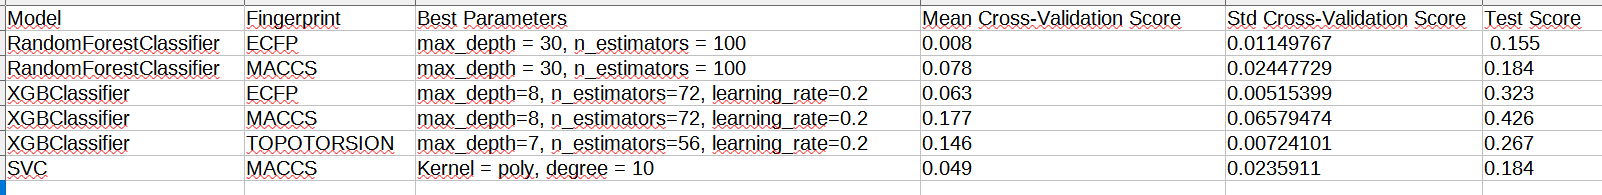